<a href="https://colab.research.google.com/github/RaminParker/Training-a-Digit-Classifier/blob/main/Training_a_Digit_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Digit Classifier

**Note:** 
- This is a *Google Colab* notebook!

**GPU:**

- Switch on the GPU accelerator for the notebook: clicking ``Runtime`` > ``Change runtime type`` > Select ``GPU`` for Hardware Accelerator.

# Import

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 194kB 14.2MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 


In [2]:
#from fastai.vision import * 
from fastai.vision.all import *

Download MNIST data set

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

Count number of items and list them:

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid')]

Check out what's in folder ``train``.

In [5]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

There is a folder of 3s, and there is a folder of 7s. Let's look inside:

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

Show one of the images:

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Image to numpy array:

In [8]:
row_start = 4
row_end = 10

col_start = 4
col_end = 10

In [9]:
array(im3)[row_start:row_end,col_start:col_end]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Image to PyTorch tensor:

In [10]:
tensor(im3)[row_start:row_end,col_start:col_end]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Use pandas df to color-code the values:

In [11]:
row_start = 4
row_end = 15

col_start = 4
col_end = 22

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[row_start:row_end,col_start:col_end])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


# Pixel Similarity

Find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give you the "ideal" number. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. 

Get tensor of every image:

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

Number of items in list:

In [13]:
len(seven_tensors), len(three_tensors)

(6265, 6131)

Show tensor as image:

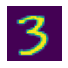

In [14]:
show_image(three_tensors[1]);

For every pixel position we want to compute the average over all the images of the intensity of that pixel. Stack all images in the list into a single 3D-tesor. This is called a ``rank-3 tensor``.

- First requirement is to convert from integer type to float type!
- Divide by 255 in order to get values between 0 and 1

In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255 # stack tensors, convert to float and divide by 255
stacked_threes = torch.stack(three_tensors).float()/255

Shape of tensor:

We see 6131 images of size 28(height)x28(width)

In [16]:
stacked_threes.shape

torch.Size([6131, 28, 28])

The rank of the tensor is the *length* of its tensor shape: length <--> rank

- **rank:** number of axis (dimensions) in a tensor
- **shape:** size of each axis of a tensor

In [17]:
len(stacked_threes.shape)

3

Different way to get the rank of tensor:

In [18]:
stacked_threes.ndim

3

Get "perfect" 3 and 7:

Take mean along axis 0 of stacked, rank-3 tensors

In [19]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

Show perfect number:

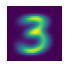

In [20]:
show_image(mean3);

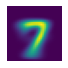

In [21]:
show_image(mean7);

Take sample image:

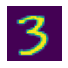

In [22]:
a_3 = stacked_threes[1]
show_image(a_3);

How to determine distance of sample "3" to image of perfect "3"?

Two main ways to measure distance:

1) L1-norm or mean absolute error --> absolute value of difference

In [23]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_7_abs = (a_3 - mean7).abs().mean()

2) L2-norm or root mean squared error --> mean of the square of the difference

Note: L2 penalies bigger mistakes more heavily than L1-norm

In [24]:
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()

Compare results:

In [25]:
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [26]:
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases the distance between our 3 and "ideal" 3 is less than the distance to the "ideal" 7 --> this is what we would expect!

In [27]:
F.l1_loss(a_3.float(), mean3) # PyTorch function for L1

tensor(0.1114)

In [28]:
F.mse_loss(a_3.float(), mean3).sqrt() # PyTorch function for L2

tensor(0.2021)

In [29]:
F.l1_loss(a_3.float(), mean7) # PyTorch function for L1

tensor(0.1586)

In [30]:
F.mse_loss(a_3.float(), mean7).sqrt() # PyTorch function for L2

tensor(0.3021)

## Numpy arrays and PyTorch tensors

- Numpy does not support using a GPU.
- Numpy does not support calculating gradients. 

Both is important for Deep Learning.

In [31]:
data = [[1,2,3], [4,5,6]] # can be a list or list of list, or list of list of lists,...

In [32]:
arr = array(data) # create array
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [33]:
tns = tensor(data) # create tensor
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

Select second row:

In [34]:
tns[1]

tensor([4, 5, 6])

Select all of second column:

In [35]:
tns[:,1]

tensor([2, 5])

Select second row from [start, end]

In [36]:
tns[1,1:3]

tensor([5, 6])

Use standart operators like +, -, *, and /

In [37]:
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

Check type of tensor:

In [38]:
tns.type()

'torch.LongTensor'

Change type automaticaly when needed:

In [39]:
tns * 1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

# Computing Metrics Using Broadcasting
The metric tells us, how good our model performce. For classification we often use ``accuracy`` as the metric.

Let's create tensors for our 3s and 7s from the validation directory to test our "model". These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [40]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]) # get tensor of every image
valid_3_tens = valid_3_tens.float()/255 # convert to float and divide by 255

In [41]:
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]) # get tensor of every image
valid_7_tens = valid_7_tens.float()/255 # convert to float and divide by 255

Shape of tensor to count number of images in stack and size of images

In [42]:
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Function that calculates distances between images based on mean absolut error (L1-norm):

In [43]:
def mnist_distance(a,b):
  return (a-b).abs().mean((-1,-2))

Input arbitrary sample ``a_3`` and "ideal" 3 ``mean3`` 

In [44]:
mnist_distance(a_3, mean3)  

tensor(0.1114)

Calculate the distance to "ideal" 3 for *every* image in the validation set:

In [45]:
valid_3_dist = mnist_distance(valid_3_tens, mean3) # distance for every single image as a vector
valid_3_dist

tensor([0.1474, 0.1071, 0.1349,  ..., 0.1343, 0.1370, 0.1305])

Note: this only works because PyTorch tries to perform a simple substraction operation between two tensors of different ranks by using ``broadcasting``. It will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. PyTorch treats ``mean3``, a rank 2 tensor representing a single image, as if it were 1010 copies of the same image, and then substracts each of those copies from each 3 in our validation set.

In [46]:
valid_3_dist.shape # length of vector

torch.Size([1010])

In [47]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

If the distance between the digit in question and the ideal 3 is less then the distance to the ideal 7, then it's a 3:

In [48]:
def is_3(x):
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

Apply function:

In [49]:
is_3(a_3)

tensor(True)

In [50]:
is_3(a_3).float() # convert Boolean response to float

tensor(1.)

Thanks to broadcasting we can test it on full validation set of 3s:

In [51]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

Calculate accuracy for each of the 3s and 7s:

In [52]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1- is_3(valid_7_tens).float()).mean()

In [53]:
accuracy_3s

tensor(0.9168)

In [54]:
accuracy_7s

tensor(0.9854)

In [55]:
(accuracy_3s + accuracy_7s) / 2

tensor(0.9511)

We're getting over 90% accuracy ob both 3s and 7s!

To imporove, let's now do some real learning --> time to talk about training process and SGD!

# Stochastic Gradient Descent (SGD)

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category.

Let's pretend that f(x) is our loss function, and x is a weight parameter of the function. If performance of model is good, the loss function returns a low number. A simmple way to figure out wheter a weight should be increased a bit or decreased a bit would be just by try it: increase the weight by a small amount, and see if the loss goes up or down. We calculate *gradients* to do this process.

In [56]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 14.9MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 1.1MB 56.6MB/s 
Mounted at /content/gdrive


In [57]:
from fastbook import *

In [58]:
def f(x):
  return x**2

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


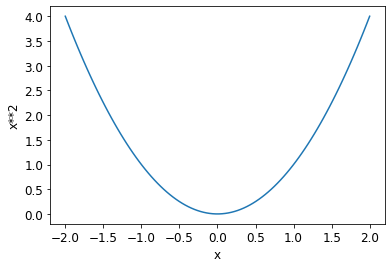

In [59]:
plot_function(f, 'x', 'x**2');

Picking some random value for a parameter, and calculating the value of the loss:

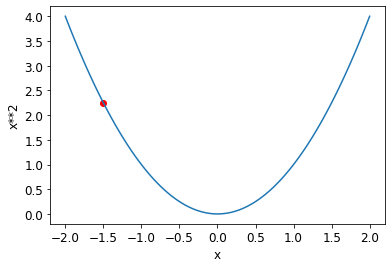

In [60]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

## Calculating Gradients

PyTorch is able to automatically compute the derivative of nearly any function!
In Deep Learning:
- gradient is not a function
- gradient is a value!

Pick a tensor value at which we want gradients:

In [61]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

Calculate value for our function (here: ``9 = 3**2``). We get:
- value
- gradient function that was used to calculate the gradient.

In [62]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Calculate gradients:
- Life would be easier if ``backward`` was just called ``calculate_grad``

In [63]:
yt.backward()

View gradients:

In [64]:
xt.grad

tensor(6.)

Repeat the preceding steps, but with a vector argument for our function 

--> values at which we want gradients!

In [65]:
xt = tensor([3., 4., 10.]).requires_grad_()

Change our function so that it can take a vector (rank-1 tensor) and return a scalar (rank-0 tensor)

In [66]:
def f(x):
  return (x**2).sum()

Calculate value for our function (here: ``125 = 3**2 + 4**2 + 10**2``). We get:

value
gradient function that was used to calculate the gradient.

In [67]:
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

As expected, our gradients are ``2*xt``:

In [68]:
yt.backward() # --> calculate gradients
xt.grad # --> view tells us the slope of our function

tensor([ 6.,  8., 20.])

- If the slope is very small, that may suggest that we are close to the optimal value.
- Gradient tells us to change our parameters in order to minimize loss
- Next, multiply gradient by some small number, called the ***learning rate***

## An End-to-End SGD Example

Create simple example to show how to use SGD.

Imagine, you were measuring the speed of your bike as it went over the top of a hump. You measured every second for 20 seconds:

In [69]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

Plot speed vs time:


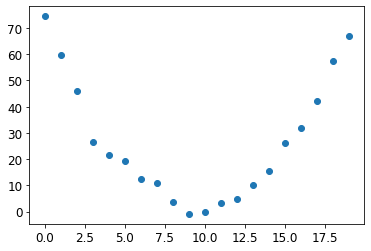

In [70]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1  # 20 data points in parabolic shape
plt.scatter(time, speed);

We guess that the function underlying is quadratic:

In [71]:
def f(t, params):
  a, b, c = params
  return a*(t**2) + (b*t) + c # general form of quadratic function

We want to find the best (quadratic) function that fits the data! Function is fully defined by the ``params`` ``a``, ``b``, ``c``.

**NOTE:** This approach can be applied to any function, for example a complex function with more parameters - such as a neural network.

Define loss-function:

- Lower loss <--> better predictions

In [72]:
def mse(preds, target):
  return ((preds-target)**2).mean()  # for continues data it's common to use mean squared error

### Step 1: Initialize the parameters
- Create 3 random values to initialize our parameters
- Tell PyTorch that we want to track their gradients using ``requires_grad_()``, so that we can later get the gradients

In [73]:
params = torch.randn(3).requires_grad_()
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

Get values of params:

In [74]:
params.data

tensor([-0.7658, -0.7506,  1.3525])

### Step 2: Calculate the predictions

In [75]:
preds = f(time, params)

Plot predictions

In [76]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

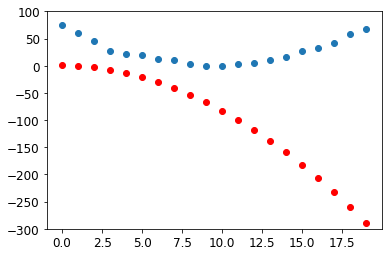

In [77]:
# blue:target, red:predictions
show_preds(preds)

### Step 3: Calculate the loss

In [78]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

### Step 4: Calculate the gradients
To improve the result, we need to know the gradients.

In [79]:
loss.backward() # calculate gradients
params.grad # view gradients

tensor([-53195.8633,  -3419.7148,   -253.8908])

Multiply with a small learning rate:

In [80]:
lr = 1e-5
params.grad * lr

tensor([-0.5320, -0.0342, -0.0025])

### Step 5: Step the weights
Update the params based on gradients:

In [81]:
params.data -= lr * params.grad.data # update params and hope that this time they fit better
params.grad = None 

Check if loss has improved (is lower):

In [82]:
preds = f(time, params) # calculate predictions again

In [83]:
mse(preds, speed) 

tensor(5435.5356, grad_fn=<MeanBackward0>)

Plot predictions:

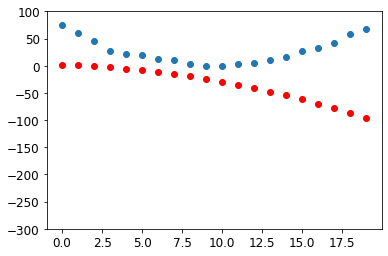

In [84]:
# blue:target, red:predictions
show_preds(preds)

### Step 6: Repeat the process
Repeat this a few times.

In [85]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

The loss is going down:

In [86]:
for i in range(20):
  apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625
676.9480590820312
676.9434814453125
676.9390869140625
676.9346923828125
676.93017578125
676.9259033203125
676.9213256835938
676.9171142578125
676.9126586914062
676.9082641601562


Plot function at every step:

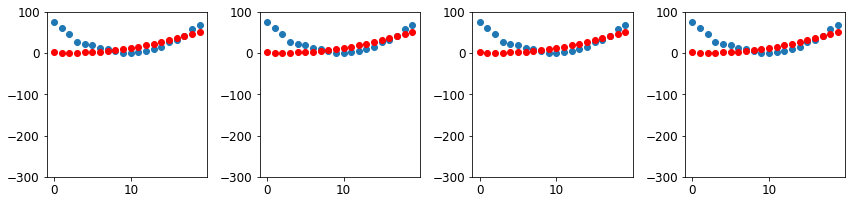

In [87]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Step 7: Stop
Stop once you are satisfied with the result

# The MNIST loss function

We take our 3D tensors and concatenate them into a single tensor

In [88]:
train_x = torch.cat([stacked_threes, stacked_sevens])

Shape of tensor:

We see 12396 images of size 28(height)x28(width)

In [90]:
train_x.shape

torch.Size([12396, 28, 28])

We change shape of single tensor from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor) without changing its content:

In [91]:
train_x = train_x.view(-1, 28*28)

Shape of tensor:

In [92]:
train_x.shape

torch.Size([12396, 784])

We need label for each image:
- ``1`` for 3s
- ``0`` for 7s

In [96]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [97]:
train_y.shape

torch.Size([12396, 1])

A ``Dataset`` in PyTorch is required to return a tuple of (x,y):

In [98]:
dset = list(zip(train_x, train_y))

Check:
- x represents a image converted as a list
- y represent label of image

In [99]:
x,y = dset[0]

In [104]:
x.shape

torch.Size([784])

In [105]:
y.shape

torch.Size([1])

We repeat steps for the validation set:

In [106]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))


Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):
- Tell PyTorch that we want to track their gradients using ``requires_grad_()``, so that we can later get the gradients

In [107]:
def init_params(size, std=1.0): 
  return (torch.randn(size)*std).requires_grad_()

In [108]:
weights = init_params((28*28, 1))

Define ``bias``:

In [109]:
bias = init_params(1)

Neural network:

``y = weights * x + bias = w * x + b``

Calculate prediction for one image:

In [110]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

Do this for each image! However, a loop in Python is too slow!

There's an extremely convenient mathematical operation that calculates ``w*x`` for every row of a matrix —it's called matrix multiplication:

In [111]:
def linear1(xb):  # multiply matrixes by using @
  return xb@weights + bias

Apply "multiply-matrix" function:

In [112]:
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

Check our aacuracy:
- if output greater than 0 then output represents 3 or 7

In [115]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [116]:
corrects.float().mean().item()

0.4912068545818329

Now we need to choose our loss function.

We need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Create a new variable, called ``trgts``, which tells wheater an image is actually a 3 or not.

In [117]:
trgts = tensor([1,0,1])  # target values represent a 3, 7 and 3
preds = tensor([0.9, 0.4, 0.2]) 

First try at a loss function.

This function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

In [119]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

Apply approach on our example:
- if predictions are perfect, each number would be 0 --> loss = 0
- it tells us, how far predictions are away from target.

In [122]:
torch.where(trgts==1, 1-preds, preds)

tensor([0.1000, 0.4000, 0.8000])

Calculate loss on our example:

In [127]:
mnist_loss(preds, trgts)

tensor(0.4333)

This function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. 

## Sigmoid